In [2]:
import numpy as np
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler 

df = pd.read_csv("football.csv")
df_understat = pd.read_csv("understat.com.csv")

# Overview

In [3]:
df.head()

,Key,Team,League,Season,Rank,Games,Wins,Draws,Losses,Points,...,Nutmegs,Controlled,DistMovedWithBall,ProgressiveDistMoved,ProgC,ProgressiveIntoFinalThird,ProgressiveInto18Yard,Miscontrols,MiscontrolsAfterTackle,ProgressivePassReceived
0,Chelsea DL 2009/2010,Chelsea,Premier League,2009/2010,1.0,38.0,27.0,5.0,6.0,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manchester United DL 2009/2010,Manchester United,Premier League,2009/2010,2.0,38.0,27.0,4.0,7.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tottenham DL 2009/2010,Tottenham,Premier League,2009/2010,4.0,38.0,21.0,7.0,10.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arsenal DL 2009/2010,Arsenal,Premier League,2009/2010,3.0,38.0,23.0,6.0,9.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aston Villa DL 2009/2010,Aston Villa,Premier League,2009/2010,6.0,38.0,17.0,13.0,8.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_understat.head()

,Unnamed: 0,Unnamed: 1,position,team,matches,wins,draws,loses,scored,missed,...,xGA,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff
0,La_liga,2014,1,Barcelona,38,30,4,4,110,21,...,28.444293,7.444293,24.727907,73.049305,5.683535,16.367593,489,114,94.0813,0.0813
1,La_liga,2014,2,Real Madrid,38,30,2,6,118,38,...,42.607198,4.607198,38.890805,47.213090,10.209085,12.929510,351,153,81.7489,-10.2511
2,La_liga,2014,3,Atletico Madrid,38,23,9,6,67,29,...,29.069107,0.069107,26.839271,25.748737,8.982028,9.237091,197,123,73.1353,-4.8647
3,La_liga,2014,4,Valencia,38,22,11,5,70,32,...,39.392572,7.392572,33.446477,16.257501,8.709827,7.870225,203,172,63.7068,-13.2932
4,La_liga,2014,5,Sevilla,38,23,7,8,71,45,...,47.862742,2.862742,41.916529,20.178070,8.276148,9.477805,305,168,67.3867,-8.6133


# Preprocessing

In [5]:
df["Start Season"] = df["Season"].apply(lambda x : int(x[:4]))
df["End Season"] = df["Season"].apply(lambda x : int(x[5:]))
df["League"].replace('La Liga', 'La_liga',inplace = True)
df["League"].replace('Premier League', 'EPL',inplace = True)

year = 2019

df_understat.rename(columns = {
    "Unnamed: 0" : "league",
    "Unnamed: 1" : "season",
    "position" : "rank"
    }, inplace = True)
pl_u = df_understat[(df_understat["league"] == "EPL") & (df_understat["season"] == year)][["rank","team", "npxGD"]].sort_values(["rank"]).reset_index(drop = True)
ll_u = df_understat[(df_understat["league"] == "La_liga") & (df_understat["season"] == year)][["rank","team", "npxGD"]].sort_values(["rank"]).reset_index(drop = True)

# SPPLBP - ShortPassesPerGameDividedbyLongBallsPerGame
# SPPLBP more - means your teams more prefer to play on the pitch instead of the sky :D


pl = df[(df["Start Season"] == year) & ((df["League"] == 'EPL') )][['Rank','League','Team','Possession','ShortPassesPerGame', 'LongBallsPerGame']].sort_values(["Rank"]).reset_index(drop = True)
pl["SPPLBP"] = pl["ShortPassesPerGame"] /pl["LongBallsPerGame"]
pl.drop(["LongBallsPerGame", "ShortPassesPerGame"], axis = 1, inplace = True)
pl["Rank"] = pl["Rank"].astype(int)
pl["npxGD"] = pl_u["npxGD"]


ll = df[(df["Start Season"] == year) & ((df["League"] == 'La_liga') )][['Rank','League','Team','Possession','ShortPassesPerGame', 'LongBallsPerGame']].sort_values(["Rank"]).reset_index(drop = True)
ll["SPPLBP"] = ll["ShortPassesPerGame"] /ll["LongBallsPerGame"]
ll.drop(["LongBallsPerGame", "ShortPassesPerGame"], axis = 1, inplace = True)
ll["Rank"] = ll["Rank"].astype(int)
ll["npxGD"] = ll_u["npxGD"]


df_prepared = pd.concat([pl,ll]).reset_index(drop = True)

In [6]:
df_prepared.head()

,Rank,League,Team,Possession,SPPLBP,npxGD
0,1,EPL,Liverpool,59.6,8.590909,32.575792
1,2,EPL,Manchester City,62.6,12.169811,58.818903
2,3,EPL,Manchester United,54.6,9.836735,19.754725
3,4,EPL,Chelsea,57.9,9.807018,31.333631
4,5,EPL,Leicester,55.1,8.600000,15.391501


In [7]:
df_prepared.tail()

,Rank,League,Team,Possession,SPPLBP,npxGD
35,16,La_liga,Deportivo Alaves,43.2,3.984848,-13.093103
36,17,La_liga,Celta Vigo,51.3,7.200000,-7.361762
37,18,La_liga,Leganes,45.0,4.164179,-5.268822
38,19,La_liga,Mallorca,46.3,5.888889,-20.254996
39,20,La_liga,Espanyol,47.5,4.571429,-13.886380


In [8]:
scaler = MinMaxScaler()
df_prepared[["Possession","SPPLBP","npxGD"]] = scaler.fit_transform(df_prepared[["Possession","SPPLBP","npxGD"]])

In [9]:
df_prepared.head()

,Rank,League,Team,Possession,SPPLBP,npxGD
0,1,EPL,Liverpool,0.924686,0.510146,0.705905
1,2,EPL,Manchester City,0.987448,0.824368,1.000000
2,3,EPL,Manchester United,0.820084,0.619527,0.562225
3,4,EPL,Chelsea,0.889121,0.616918,0.691985
4,5,EPL,Leicester,0.830544,0.510944,0.513329


In [10]:
overview = px.scatter_3d(df_prepared, x = 'Possession', y = 'SPPLBP', z = 'npxGD', hover_name = 'Team')
overview.show()

# KMeans Clustering 

In [11]:
RS = 42
n = 3
kmeans_v1 = KMeans(n_clusters = n, max_iter = 300, random_state = RS)
kmeans_v1.fit(df_prepared[["Possession","SPPLBP","npxGD"]])
df_prepared["cluster"] = kmeans_v1.labels_
kmeans_v1_fig = px.scatter_3d(df_prepared, x = 'Possession', y = 'SPPLBP', z = 'npxGD', hover_name = 'Team', color = 'cluster', title = 'n = 3')
kmeans_v1_fig.show()

## Tuning

In [12]:
distortions = []
K = range(1, 10)

for k in K:
	kmeanModel = KMeans(n_clusters=k, random_state = RS)
	kmeanModel.fit(df_prepared[["Possession","SPPLBP","npxGD"]])

	
	cdist_result = cdist(df_prepared[["Possession","SPPLBP","npxGD"]], kmeanModel.cluster_centers_,'euclidean')
	minimum_cdist = np.min(cdist_result, axis = 1)
	sum_minimum_cdsit = np.sum(minimum_cdist)
	avg_cdist = sum_minimum_cdsit / df_prepared.shape[0]

	distortions.append(avg_cdist)

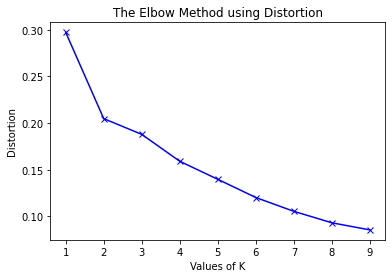

In [13]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

## Final KMeans

In [14]:
n = 6
kmeans_v2 = KMeans(n_clusters = n, max_iter = 3000, random_state = RS)
kmeans_v2.fit(df_prepared[["Possession","SPPLBP","npxGD"]])
df_prepared["cluster"] = kmeans_v2.labels_ + 1
title_kmeans_v2 = f'Clustering EPL & La Liga Teams (kmean method, n = {n})'
kmeans_v2_fig = px.scatter_3d(df_prepared, x = 'Possession', y = 'SPPLBP', z = 'npxGD', hover_name = 'Team', color = 'cluster', title = title_kmeans_v2 )
kmeans_v2_fig.update_layout(title_x = 0.5)
kmeans_v2_fig.show()

In [15]:
df_prepared.to_csv("results.csv", index = False)

In [16]:
df_prepared

,Rank,League,Team,Possession,SPPLBP,npxGD,cluster
0,1,EPL,Liverpool,0.924686,0.510146,0.705905,4
1,2,EPL,Manchester City,0.987448,0.824368,1.000000,1
2,3,EPL,Manchester United,0.820084,0.619527,0.562225,4
3,4,EPL,Chelsea,0.889121,0.616918,0.691985,4
4,5,EPL,Leicester,0.830544,0.510944,0.513329,4
5,6,EPL,Tottenham,0.755230,0.456669,0.307601,6
6,7,EPL,Wolverhampton,0.696653,0.242642,0.522594,2
7,8,EPL,Arsenal,0.784519,0.491396,0.313176,6
8,9,EPL,Sheffield United,0.606695,0.139106,0.307729,2
9,10,EPL,Burnley,0.596234,0.081814,0.288077,2
